Fitting 3 folds for each of 60 candidates, totalling 180 fits


[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.5s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.5s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   2.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   2.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   2.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   3.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   3.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   3.3s
[CV] END ...learning_rate=0.

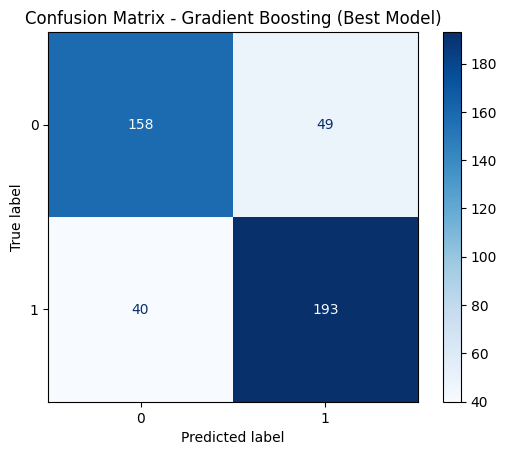

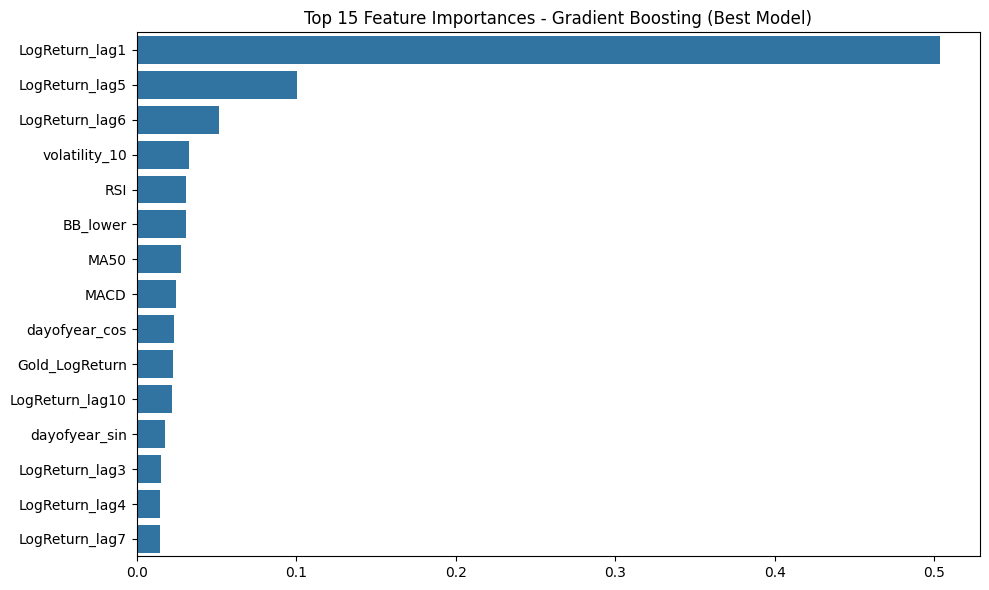

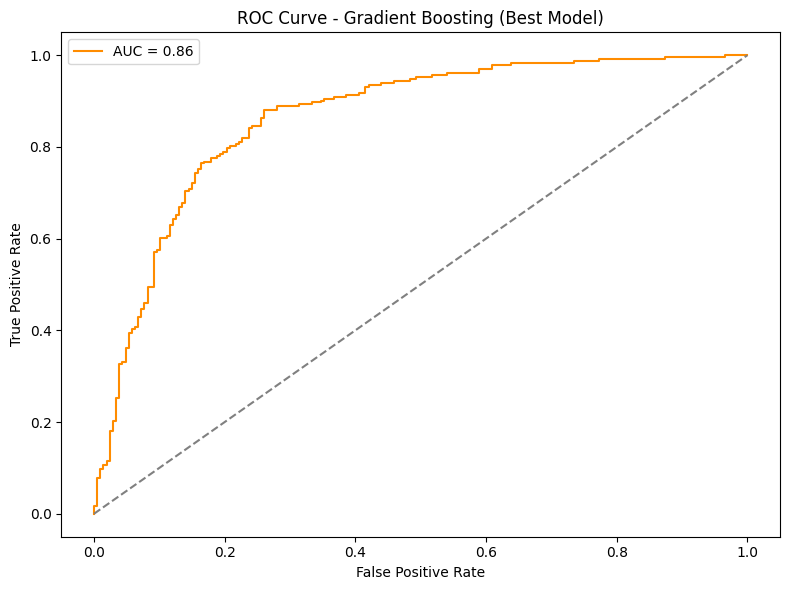

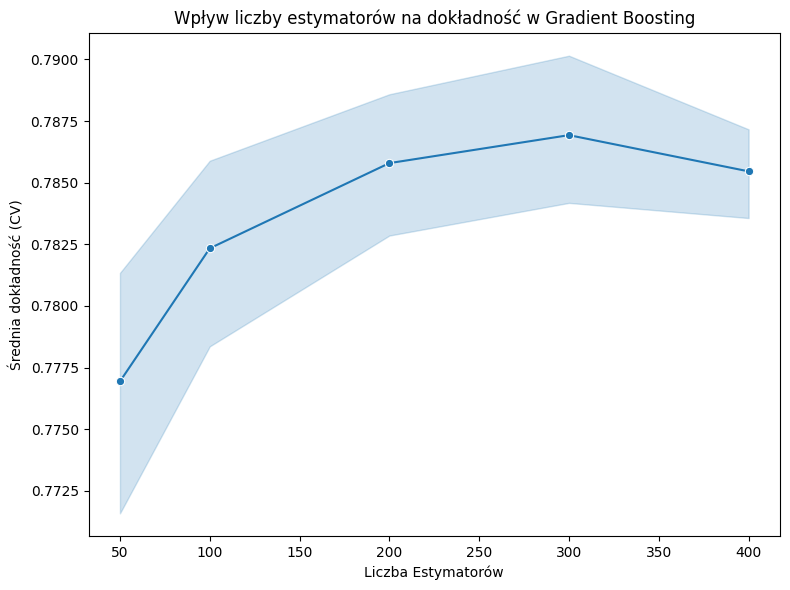

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Wczytanie i przygotowanie danych
data = pd.read_csv('data_final.csv')
data_class = data.copy()

# Binarna klasyfikacja: 1 jeśli LogReturn > 0, w przeciwnym razie 0
data_class['LogReturn'] = (data_class['LogReturn'] > 0).astype(int)

# Zmienne niezależne i zależna
X = data_class.drop(['LogReturn'], axis=1)
Y = data_class['LogReturn']
feature_names = X.columns  # Zachowanie nazw cech

# Skalowanie danych
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Parametry do GridSearch
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Inicjalizacja i przeprowadzenie GridSearchCV
gb_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb_model, param_grid, cv=3, n_jobs=-1, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

# Najlepszy model z GridSearchCV
best_model = grid_search.best_estimator_

# Predykcja na zbiorze testowym
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]  # Do krzywej ROC

# Ocena
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Gradient Boosting Accuracy: {accuracy * 100:.2f}%")
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall   : {recall * 100:.2f}%")

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# --- MACIERZ POMYŁEK ---
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Gradient Boosting (Best Model)")
plt.show()

# --- FEATURE IMPORTANCE (TOP 15) ---
importances = best_model.feature_importances_
indices = importances.argsort()[::-1][:15]  # Tylko top 15

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=[feature_names[i] for i in indices])
plt.title("Top 15 Feature Importances - Gradient Boosting (Best Model)")
plt.tight_layout()
plt.show()

# --- ROC CURVE ---
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting (Best Model)')
plt.legend()
plt.tight_layout()
plt.show()

# --- WIZUALIZACJA WPŁYWU LICZBY ESTYMATORÓW NA DOKŁADNOŚĆ ---
results_df = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(8, 6))
sns.lineplot(data=results_df, x='param_n_estimators', y='mean_test_score', marker='o')
plt.title('Wpływ liczby estymatorów na dokładność w Gradient Boosting')
plt.xlabel('Liczba Estymatorów')
plt.ylabel('Średnia dokładność (CV)')
plt.tight_layout()
plt.show()



In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

# Wczytanie danych
data = pd.read_csv('data_final.csv')
data_class = data.copy()

# Binarna klasyfikacja
data_class['LogReturn'] = (data_class['LogReturn'] > 0).astype(int)

# Zmienne
X = data_class.drop(['LogReturn'], axis=1)
Y = data_class['LogReturn']

# Skalowanie
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Podział
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Parametry do przeszukania
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5],
}

# GridSearch
gb = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Najlepszy model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Best Gradient Boosting Accuracy: {accuracy * 100:.2f}%")
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 3 folds for each of 72 candidates, totalling 216 fits


Best Gradient Boosting Accuracy: 80.00%
Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.76      0.78       207
           1       0.80      0.84      0.82       233

    accuracy                           0.80       440
   macro avg       0.80      0.80      0.80       440
weighted avg       0.80      0.80      0.80       440

Confusion Matrix:
 [[157  50]
 [ 38 195]]


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

# Wczytanie danych
data = pd.read_csv('data_final.csv')
data_class = data.copy()

# Obliczanie kwartylów
q1 = data['LogReturn'].quantile(0.25)  # 25. percentyl
q2 = data['LogReturn'].quantile(0.50)  # 50. percentyl (mediana)
q3 = data['LogReturn'].quantile(0.75)  # 75. percentyl

# Przekształcanie 'LogReturn' na 4 klasy na podstawie kwartylów
data_class['LogReturn'] = pd.cut(data['LogReturn'], bins=[-float('inf'), q1, q2, q3, float('inf')],
                                  labels=[0, 1, 2, 3])

# Przygotowanie zmiennych X i Y
X = data_class.drop(['LogReturn'], axis=1)
Y = data_class['LogReturn']

# Podział na zestaw treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Parametry do przeszukania
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4],
    'subsample': [0.8, 1.0],
}

# GridSearch
gb = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Najlepszy model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Obliczanie miar
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Average 'weighted' because it is multi-class
recall = recall_score(y_test, y_pred, average='weighted')

# Wyniki
print(f"\nBest Gradient Boosting Accuracy (4-class): {accuracy * 100:.2f}%")
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Precision i Recall
print(f"\nPrecision (Weighted): {precision * 100:.2f}%")
print(f"Recall (Weighted): {recall * 100:.2f}%")


Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best Gradient Boosting Accuracy (4-class): 56.36%
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.76      0.72       104
           1       0.52      0.42      0.47       125
           2       0.40      0.47      0.43       106
           3       0.65      0.63      0.64       105

    accuracy                           0.56       440
   macro avg       0.57      0.57      0.57       440
weighted avg       0.57      0.56      0.56       440

Confusion Matrix:
 [[79 13  4  8]
 [26 53 39  7]
 [ 8 28 50 20]
 [ 1  7 31 66]]

Precision (Weighted): 56.60%
Recall (Weighted): 56.36%
